In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')


2023-10-27 15:51:34.556863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-27 15:51:34.556888: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


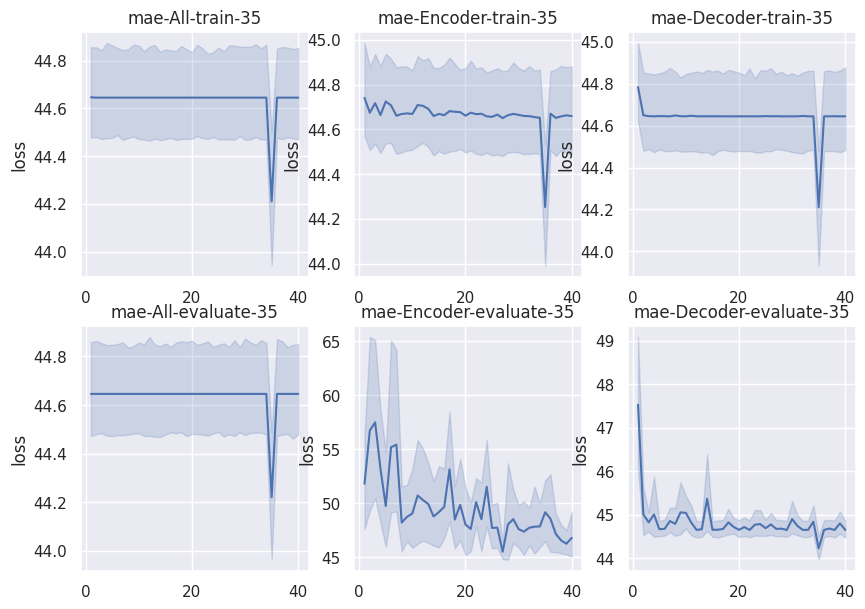

In [3]:
f, axs= plt.subplots(2, 3, figsize = (10,7))
models = ['All', 'Encoder', 'Decoder', 'All', 'Encoder', 'Decoder']
loss= 'mae'
for i, model in enumerate(models):
    train_evaluate = 'train'
    l = 0
    c = i
    if i>2:
        train_evaluate = 'evaluate'
        l = 1
        c = i-3
    data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss'])
    sns.lineplot(data = data, x = 'round', y = 'loss', ax = axs[l][c])
    axs[l][c].set_title(f'{loss}-{model}-{train_evaluate}-35')
    axs[l][c].set_xlabel('')

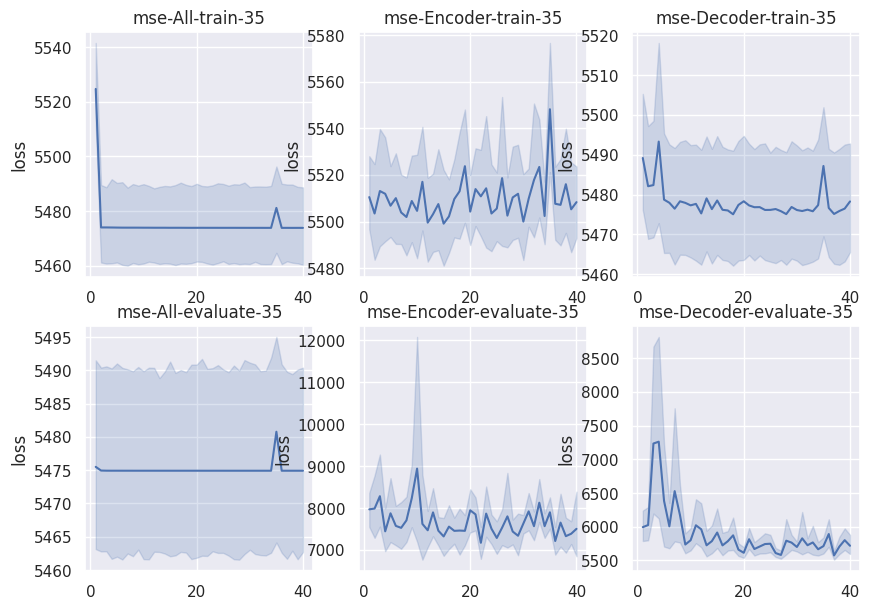

In [4]:
f, axs= plt.subplots(2, 3, figsize = (10,7))
models = ['All', 'Encoder', 'Decoder', 'All', 'Encoder', 'Decoder']
loss= 'mse'
for i, model in enumerate(models):
    train_evaluate = 'train'
    l = 0
    c = i
    if i>2:
        train_evaluate = 'evaluate'
        l = 1
        c = i-3
    data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss'])
    sns.lineplot(data = data, x = 'round', y = 'loss', ax = axs[l][c])
    axs[l][c].set_title(f'{loss}-{model}-{train_evaluate}-35')
    axs[l][c].set_xlabel('')
    

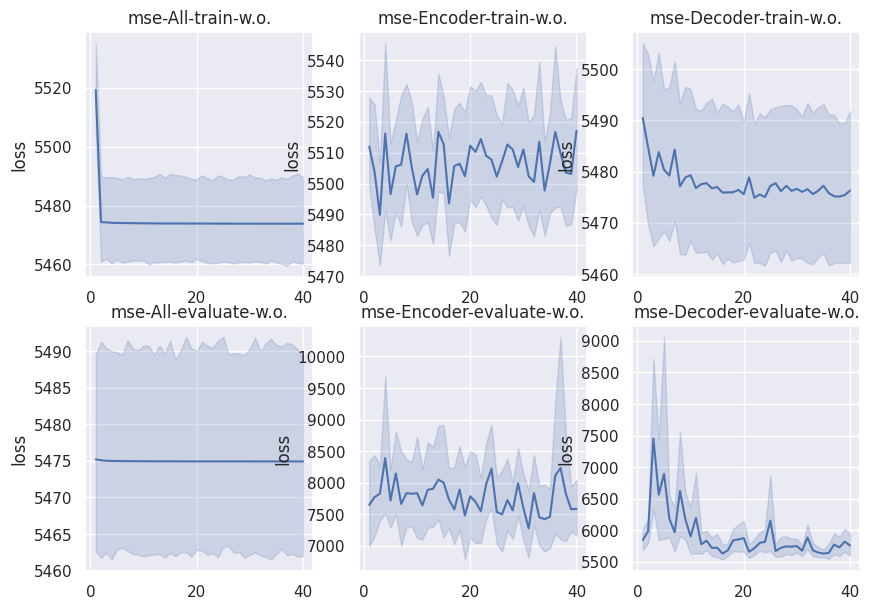

In [5]:
f, axs= plt.subplots(2, 3, figsize = (10,7))
models = ['All', 'Encoder', 'Decoder', 'All', 'Encoder', 'Decoder']
loss= 'mse'
for i, model in enumerate(models):
    train_evaluate = 'train'
    l = 0
    c = i
    if i>2:
        train_evaluate = 'evaluate'
        l = 1
        c = i-3
    data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/wo_anomaly/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss'])
    sns.lineplot(data, x = 'round', y = 'loss', ax = axs[l][c])
    axs[l][c].set_title(f'{loss}-{model}-{train_evaluate}-w.o.')
    axs[l][c].set_xlabel('')

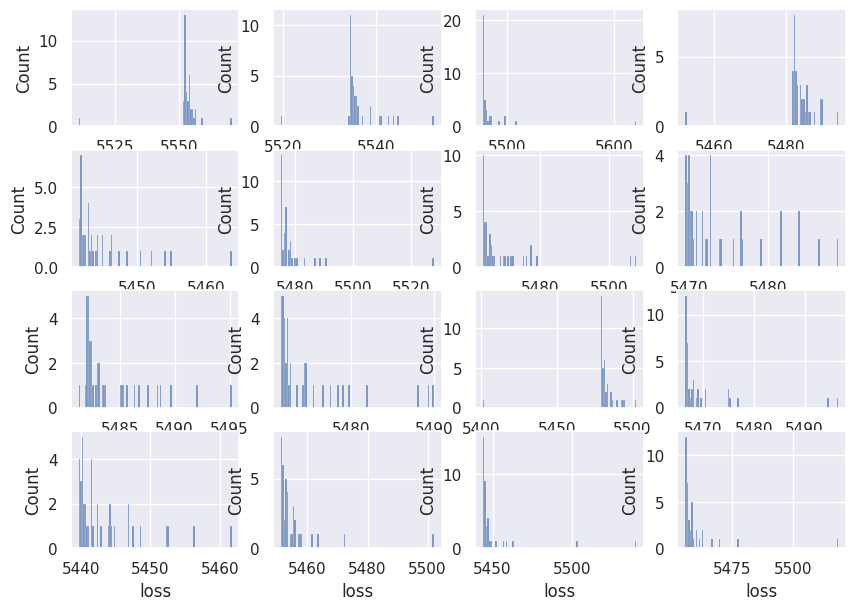

In [6]:
data = pd.read_csv('/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/train/loss_mse_Decoder.csv', names = ['cid', 'round', 'loss'])
#sns.lineplot(data = data.groupby('round').mean(), x = 'round', y = 'loss')
f, ax = plt.subplots(4, 4, figsize = (10,7))
axs = ax.flatten()

for i in range(16):
    sns.histplot(data = data[data['cid'] == i][data['round']>1], x = 'loss', bins = 100, ax = axs[i])

<AxesSubplot:xlabel='round', ylabel='loss'>

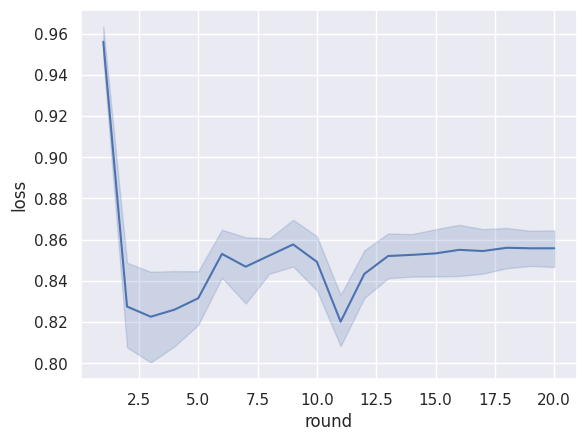

In [7]:
loss = 'mse'
model = 'Decoder'
train_evaluate = 'train'
data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/teste2/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss','diff', 'anomaly', 'true_anomaly'])
sns.lineplot(data = data, x = 'round', y = 'loss')

In [ ]:
# 4 - com finetunning e sem dados globais
# 5 - sem treino, apenas evaluate do modelo pretreinado e com dados globais
# 6 - com fine tunning do modelo pre treinado e com dados grobais
# 7 - sem fine tunning e sem dados globais
# 8 - com fine tunning e sem dados globais
# 9 - treinamento do zero e sem dados globais
# 10 - treinamento do zero e com dados globais

<AxesSubplot:xlabel='round', ylabel='loss'>

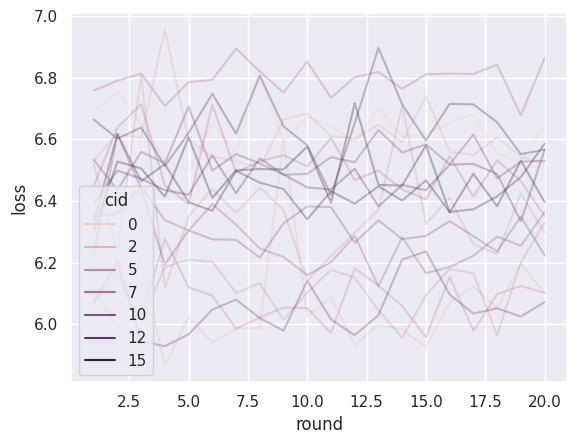

In [78]:
loss = 'mse'
model = 'Decoder'
train_evaluate = 'evaluate'
data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/teste9/logs/SKAB/CNN/{train_evaluate}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss','diff', 'anomaly', 'true_anomaly'])
sns.lineplot(data , x = 'round', y = 'loss', hue='cid', alpha = 0.3)

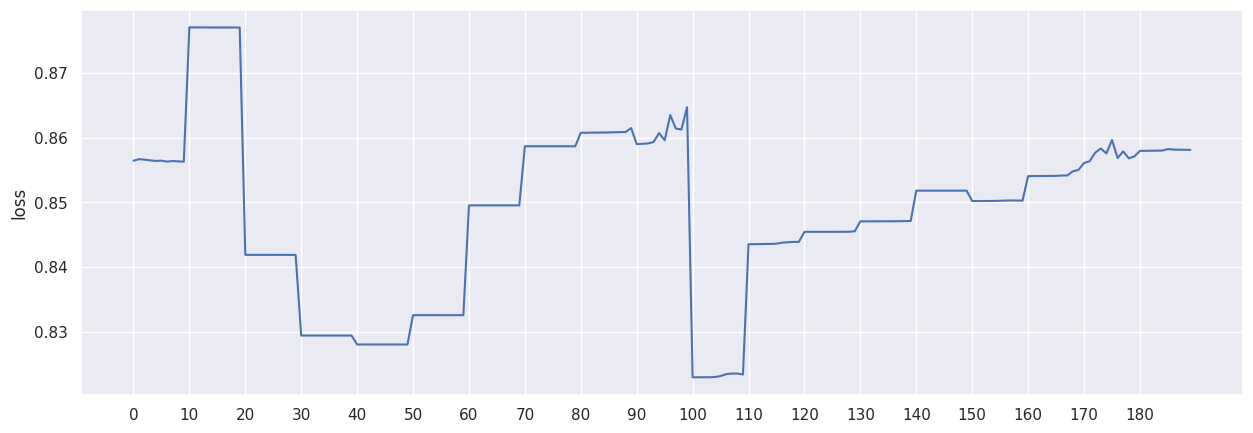

In [62]:
fig, ax = plt.subplots(figsize=(15,5))

loss = 'mse'
model = 'All'
train_evaluate = 'train'
data2 = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/teste78/logs/SKAB/CNN/{train_evaluate}/5/loss_{loss}_{model}.csv', names = ['round', 'cid',  'loss', '-', '--'])
sns.lineplot(data = data2, x = range(len(data2)), y = 'loss', ax=ax)
ax.set_xticks(list(range(len(data2)))[::10])
valores = data2['loss'].values[::10]

In [35]:
#modelo pre treinado
#federar o anomaly free
#treinar apenas ate o round 10
#
#plotar as time series


#modelo pre treinado e dados locais (com treino)
#modelo pre treinado e dados locais (so teste)

#modelo pre treinado e 

<AxesSubplot:xlabel='round', ylabel='loss'>

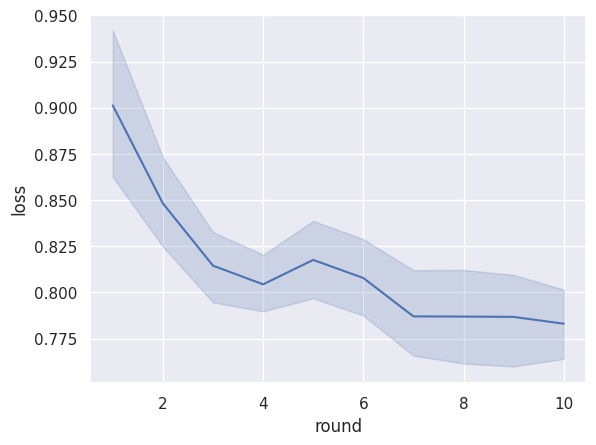

In [454]:
test_name = 'PCA2_w_local_training_wo_global_data'
loss = 'mse'
model = 'All'
train_evaluate = 'train'
data = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/{test_name}/{train_evaluate}/loss_{loss}_{model}.csv',
                   names = ['cid', 'round', 'loss','diff', 'anomaly', 'anomaly2', 'true_anomaly'])
sns.lineplot(data, x = 'round', y = 'loss')#, hue='cid', alpha = 0.3)

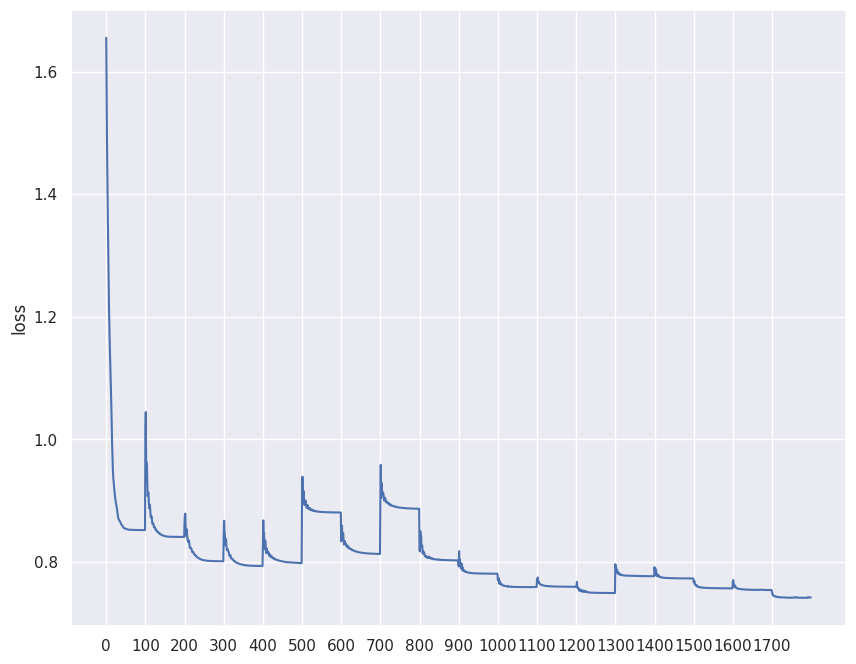

In [460]:
loss = 'mse'
model = 'All'
train_evaluate = 'train'
test_name = 'PCA2_w_local_training_wo_global_data'
cid = 2

plt.figure(figsize = (10,8))
data2 = pd.read_csv(f'/home/gabrieltalasso/IoT_Anomaly_Detection/logs/SKAB/CNN/{test_name}/{train_evaluate}/{cid}/loss_{loss}_{model}.csv', names = ['cid', 'round', 'loss','diff', 'anomaly', 'true_anomaly'])
sns.lineplot(data = data2, x = range(len(data2)), y = 'loss')
plt.xticks(list(range(len(data2)))[::100]);

<AxesSubplot:xlabel='diff', ylabel='Count'>

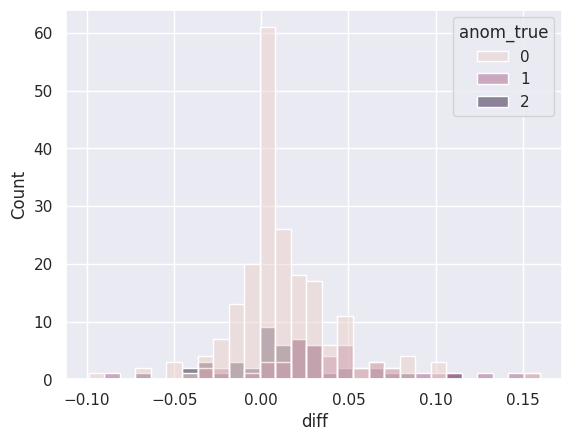

In [462]:
data = pd.read_csv('logs/SKAB/CNN/PCA2_w_local_training_wo_global_data/train/loss_mse_All.csv',
                   names = ['cid', 'round', 'loss', 'diff', 'anom', 'anom2', 'anom_true'])
data['anom_true'] = data['round'].apply(lambda x: 1 if x==3 or x==4 or x==5 else (2 if x==9 or x==10 or x==11 else 0))


sns.histplot(x = data['diff'], hue = data['anom_true'])

In [421]:
1.5*data['diff'].mean()#*1.5


0.023128661602438462